## Predicting Default rate through ensemble learning 
In this script, we attempt to determine whether to lend a customer money by first predicting the loan default probability based on the loan info and customer's demographic info, and then calculate the 
We performed stacking on five binary classifcation models, which consist of a logistic regression, a decision tree classifier, a random forest model, a gradient boosting model, and a xgboost model.Stacking is an ensemble learning method that predicts the default rate of the customer by the predicted default rate from all the models.  
The finary stacking model that we chose in the mean probability predicted by the five models, because it has the highest AUC.
The threshold (0.83) for determining whether to lend is determined by finding the threshold that creates the highest expected earning, assuming that the defaulter does not pay any interest or principal, that the interest rates for all loans are simple interest rates, and that the borrowers would take exactly the time length of the loan term to repay their loans.
Ideally, if we have data on the time of the default, we could calculate the monthly default rate for a loan, allowing us to determine more accurately the threshold that optimizes the expected profit from a customer.

Key words:
1. Hyperparameter tuning
2. Missing data imputation
3. Stacking
4. Machine learning
5. Binary classification



In [763]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import t

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [764]:
df = pd.read_csv("logistic_regression.txt")

# Data investigation:



checking missing values

In [765]:
def missing_df(data):
    total_missing_df = data.isna().sum().sort_values(ascending = False)
    percentage_missing_df = ((data.isna().sum()/len(data)*100)).sort_values(ascending = False)
    missingDF = pd.concat([total_missing_df, percentage_missing_df],axis = 1, keys=['Total', 'Percent'])
    return missingDF


missing_data = missing_df(df)
missing_data[missing_data["Total"]>0]


,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1755,0.443148
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


In [769]:
df["loan_status"].value_counts(normalize=True)*100

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

- #### As we can see, there is an imbalance in the data. We will need oversampling later on in this script

In [1098]:
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

                      loan_amnt  int_rate  annual_inc  loan_status       dti  open_acc   pub_rec  revol_bal  revol_util  total_acc  mort_acc  pub_rec_bankruptcies
loan_amnt              1.000000  0.174015    0.326752     0.066410  0.043353  0.192419 -0.095667   0.327628    0.098726   0.221549  0.209331             -0.090698
int_rate               0.174015  1.000000   -0.057989     0.250229  0.175585  0.014599  0.068352  -0.010364    0.292328  -0.033378 -0.088695              0.062645
annual_inc             0.326752 -0.057989    1.000000    -0.050360 -0.174160  0.130525 -0.026316   0.296280    0.025479   0.190682  0.198313             -0.041988
loan_status            0.066410  0.250229   -0.050360     1.000000  0.131137  0.032034  0.015881  -0.009984    0.080959  -0.015055 -0.067623              0.006918
dti                    0.043353  0.175585   -0.174160     0.131137  1.000000  0.306275 -0.041429   0.142841    0.193692   0.230017 -0.022838             -0.020397
open_acc              

In [770]:
df.drop("installment",axis = 1 , inplace=True)

In [772]:
df["home_ownership"].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [773]:
df["home_ownership"].replace({"ANY":"OTHER",
                             "NONE":"OTHER"},
                            inplace=True)

In [777]:
df["title"].nunique()

41327

There are too many titles. Allowing them to be predictors would significantly increase the chance of overfitting. We will drop them later on in this script

#### Changing data types of Date time columns :" 

In [778]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

## Feature Engineering  : 



In [779]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [780]:
df['pub_rec'] = df.pub_rec.apply(pub_rec)
df['mort_acc'] = df.mort_acc.apply(mort_acc)
df['pub_rec_bankruptcies'] = df.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

## Converting target values : 
- ### if loanStatus is Fully Paid : 0
- ### if loanStatus is Charged Off : 1

In [782]:
df["loan_status"] = df["loan_status"].map({"Fully Paid":0,
                      "Charged Off":1})

### keeping an eye on missing values 

In [783]:
# (df.isna().sum()/df.shape[0]) *100

In [784]:
missing_data[missing_data["Percent"]>0]

,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1755,0.443148
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


## Mean Value Imputation : Target Encoding : 

filling total_acc_avg with group average

In [786]:
total_acc_avg = df.groupby(by='total_acc').mean().mort_acc


In [788]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [789]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']),axis = 1)

In [790]:
missing_data[missing_data["Percent"]>0]

,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1755,0.443148
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


In [791]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [792]:
df["emp_title"].nunique()

173105

### Target Encoding for "pub_rec_bankruptcies":

#### Since there are 535 missing records of public record bankrupcies , we cannot remove them blindly or can impute with the most frequent. so , giving them some probability value of pub_rec_bankruptcy is a good idea. 
#### replacing those missing values with target encoding

In [793]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

0.0    350380
1.0     45115
NaN       535
Name: pub_rec_bankruptcies, dtype: int64

In [795]:
from category_encoders import TargetEncoder
TE = TargetEncoder()

In [796]:
df["pub_rec_bankruptcies"] = df["pub_rec_bankruptcies"].fillna("Record_not_cound").astype("str")

In [797]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

0.0                 350380
1.0                  45115
Record_not_cound       535
Name: pub_rec_bankruptcies, dtype: int64

In [798]:
df["pub_rec_bankruptcies"] = TE.fit_transform(df["pub_rec_bankruptcies"],df["loan_status"])

In [799]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

0.194991    350380
0.205364     45115
0.162617       535
Name: pub_rec_bankruptcies, dtype: int64

In [1104]:
df = df.drop(['emp_title', 'title'], axis = 1)

In [1105]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt               0.0
term                    0.0
int_rate                0.0
grade                   0.0
sub_grade               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

In [1102]:
df.shape

(371126, 26)

## Dropping rest of the missing values : 

In [802]:
df.dropna(inplace=True)

In [803]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt               0.0
term                    0.0
int_rate                0.0
grade                   0.0
sub_grade               0.0
emp_title               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
title                   0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

### Outlier Detection & Treatment  : 

In [804]:
numerical_data = df.select_dtypes(include='number')
numerical_data

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,10000.0,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,25.0,0.0,0.194991
1,8000.0,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,27.0,1.0,0.194991
2,15600.0,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,26.0,0.0,0.194991
3,7200.0,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,13.0,0.0,0.194991
4,24375.0,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,43.0,1.0,0.194991
...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,10.99,40000.0,0,15.63,6.0,0,1990.0,34.3,23.0,0.0,0.194991
396026,21000.0,12.29,110000.0,0,21.45,6.0,0,43263.0,95.7,8.0,1.0,0.194991
396027,5000.0,9.99,56500.0,0,17.56,15.0,0,32704.0,66.9,23.0,0.0,0.194991
396028,21000.0,15.31,64000.0,0,15.88,9.0,0,15704.0,53.8,20.0,1.0,0.194991


In [805]:
num_cols = numerical_data.columns
len(num_cols)

12

In [806]:
num_cols = ['loan_amnt', 'int_rate', 'annual_inc',  'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc' ]

In [807]:
# def box_plot(col):
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(x=df[col])
#     plt.title('Boxplot')
#     plt.show()

# for col in num_cols:
#     box_plot(col)


In [808]:
removed_ooutlier = df.copy()

In [809]:
for col in num_cols:
    mean = removed_ooutlier[col].mean()
    std = removed_ooutlier[col].std()
    upper_limit = mean+3*std
    lower_limit = mean-3*std
    removed_ooutlier = removed_ooutlier[(removed_ooutlier[col]<upper_limit) & (removed_ooutlier[col]>lower_limit)]
removed_ooutlier.shape

(355005, 26)

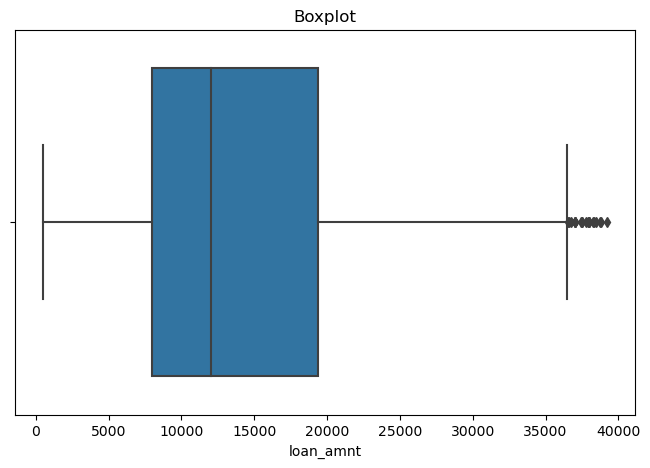

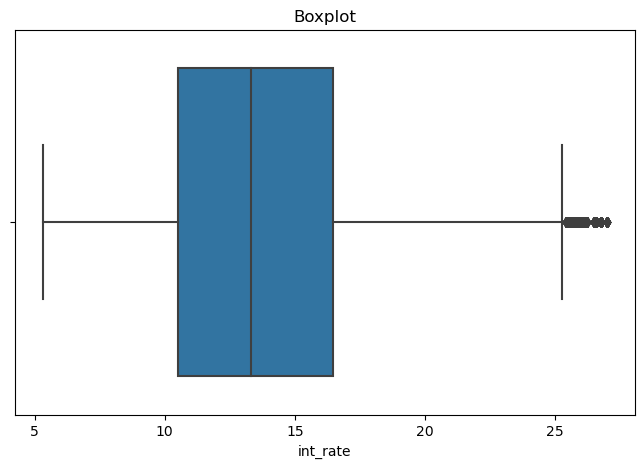

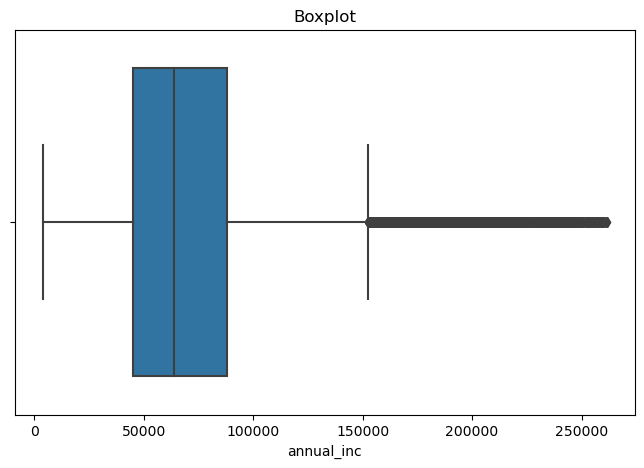

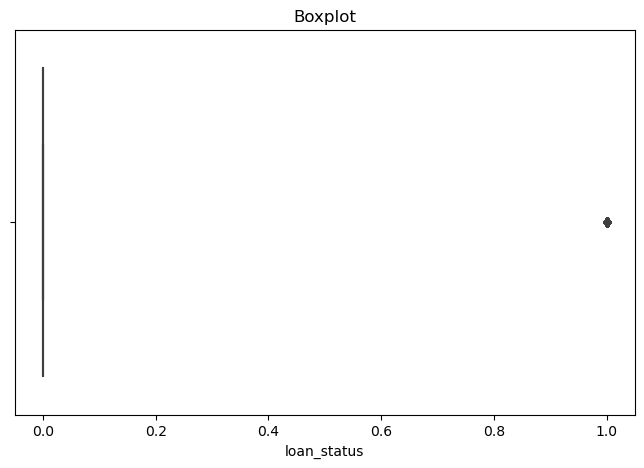

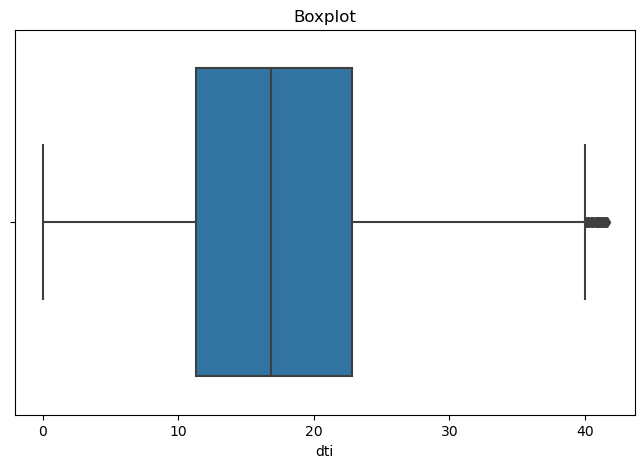

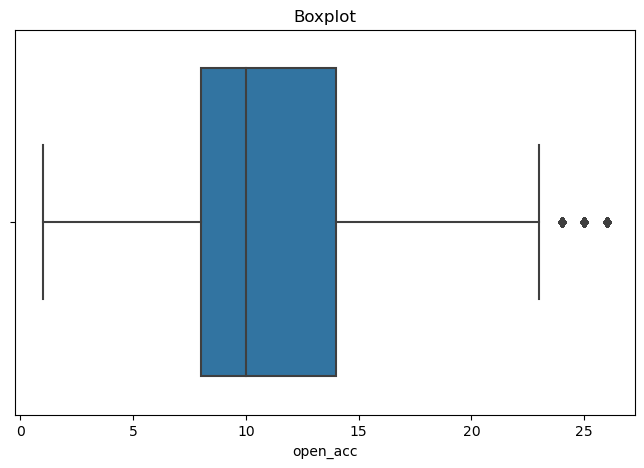

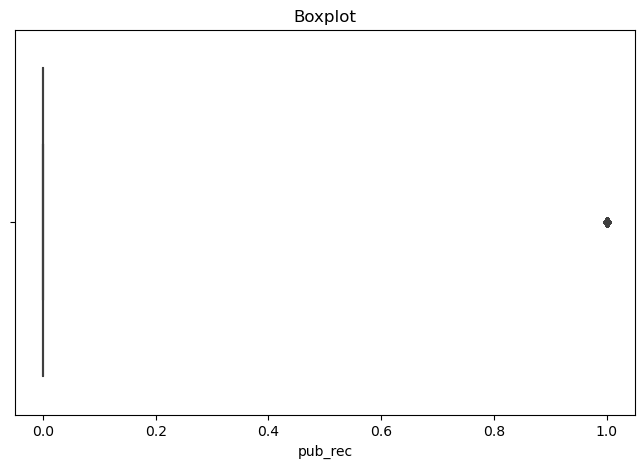

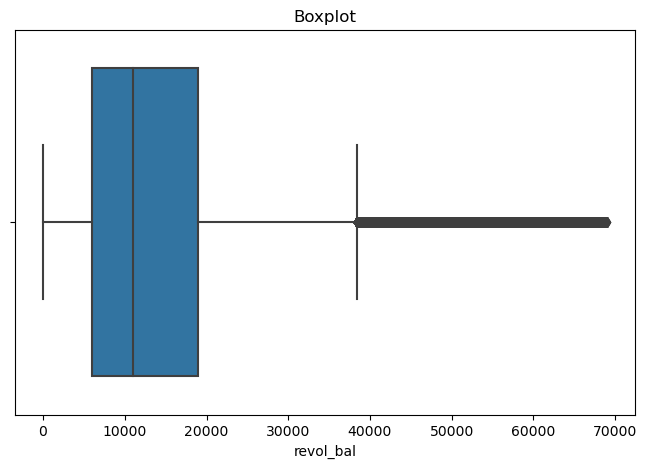

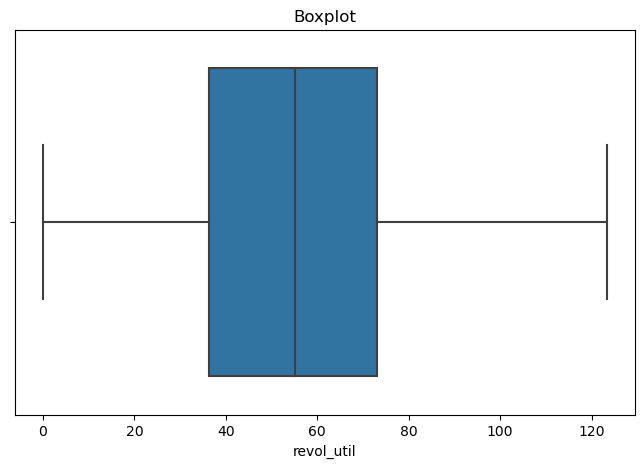

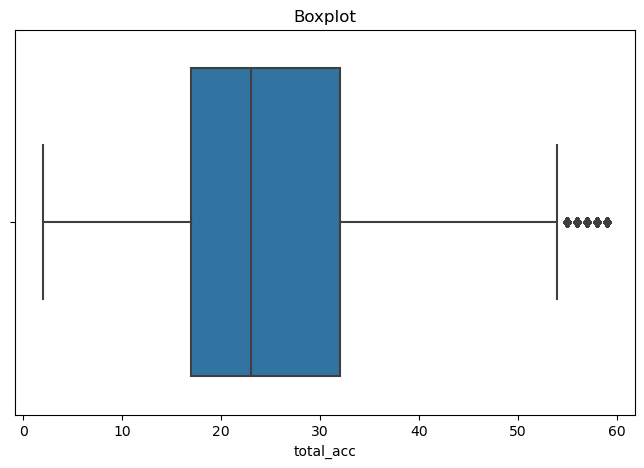

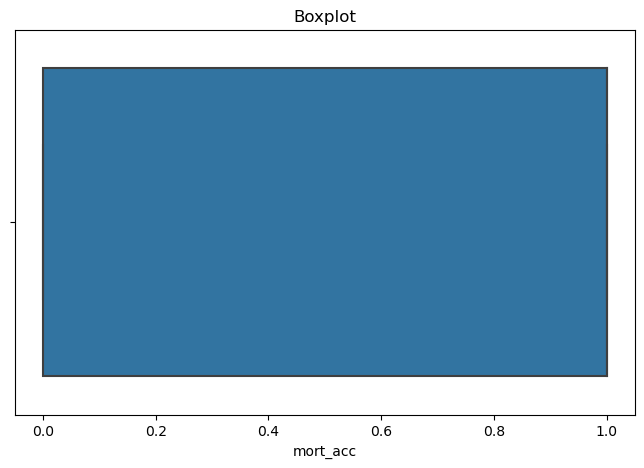

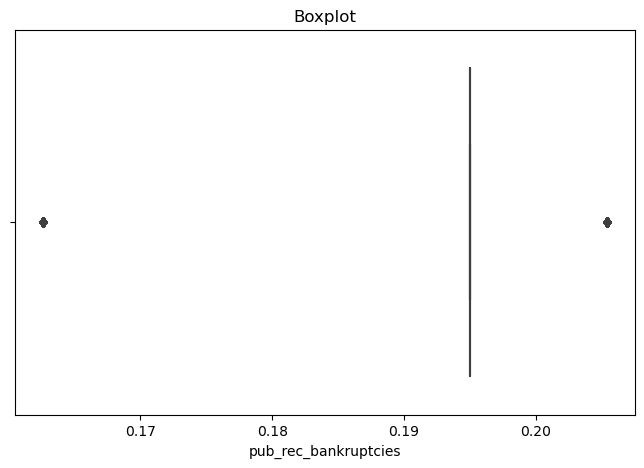

In [810]:
numerical_data = removed_ooutlier.select_dtypes(include='number')
numerical_data

num_cols = numerical_data.columns
len(num_cols)
def box_plot(col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=removed_ooutlier[col])
    plt.title('Boxplot')
    plt.show()

for col in num_cols:
    box_plot(col)


In [811]:
# removed_ooutlier.pub_rec_bankruptcies.value_counts()

In [812]:
data = removed_ooutlier.copy()

## Data Preprocessing -

In [813]:

data['term'] = data.term.map({' 36 months': 36, ' 60 months': 60})


In [814]:

data['initial_list_status'] = data.initial_list_status.map({'w': 0, 'f': 1})


In [815]:
data.address.apply(lambda x: x[-5:])

0         22690
1         05113
2         05113
3         00813
4         11650
          ...  
396025    30723
396026    05113
396027    70466
396028    29597
396029    48052
Name: address, Length: 355005, dtype: object

In [816]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])


In [817]:
data['zip_code'].value_counts(normalize=True)*100

70466    14.378671
30723    14.282616
22690    14.269095
48052    14.125153
00813    11.611949
29597    11.537302
05113    11.517021
93700     2.773764
11650     2.771229
86630     2.733201
Name: zip_code, dtype: float64

In [818]:
# dropping iirrelevant features : 
data.drop(columns=['issue_d',  'sub_grade','address', 'earliest_cr_line', 'emp_length'], axis=1, inplace=True)


In [819]:
data.drop("title",inplace=True,axis = 1)

In [820]:
data["emp_title"].nunique() # target_encoding

167202

In [821]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_title', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code'], dtype='object')

### Target encoding for employee title : 

In [822]:
from category_encoders import TargetEncoder
TE = TargetEncoder()

data["emp_title"] = TE.fit_transform(data["emp_title"],data["loan_status"])

In [823]:
# data["emp_title"] = TE.fit_transform(data["emp_title"],data["loan_status"])

In [824]:
data

,loan_amnt,term,int_rate,grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
0,10000.0,36,11.44,B,0.243798,RENT,117000.0,Not Verified,0,vacation,26.24,16.0,0,36369.0,41.8,25.0,0,INDIVIDUAL,0.0,0.194991,22690
1,8000.0,36,11.99,B,0.214179,MORTGAGE,65000.0,Not Verified,0,debt_consolidation,22.05,17.0,0,20131.0,53.3,27.0,1,INDIVIDUAL,1.0,0.194991,05113
2,15600.0,36,10.49,B,0.194452,RENT,43057.0,Source Verified,0,credit_card,12.79,13.0,0,11987.0,92.2,26.0,1,INDIVIDUAL,0.0,0.194991,05113
3,7200.0,36,6.49,A,0.167377,RENT,54000.0,Not Verified,0,credit_card,2.60,6.0,0,5472.0,21.5,13.0,1,INDIVIDUAL,0.0,0.194991,00813
4,24375.0,60,17.27,C,0.297485,MORTGAGE,55000.0,Verified,1,credit_card,33.95,13.0,0,24584.0,69.8,43.0,1,INDIVIDUAL,1.0,0.194991,11650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60,10.99,B,0.167377,RENT,40000.0,Source Verified,0,debt_consolidation,15.63,6.0,0,1990.0,34.3,23.0,0,INDIVIDUAL,0.0,0.194991,30723
396026,21000.0,36,12.29,C,0.208092,MORTGAGE,110000.0,Source Verified,0,debt_consolidation,21.45,6.0,0,43263.0,95.7,8.0,1,INDIVIDUAL,1.0,0.194991,05113
396027,5000.0,36,9.99,B,0.271928,RENT,56500.0,Verified,0,debt_consolidation,17.56,15.0,0,32704.0,66.9,23.0,1,INDIVIDUAL,0.0,0.194991,70466
396028,21000.0,60,15.31,C,0.167377,MORTGAGE,64000.0,Verified,0,debt_consolidation,15.88,9.0,0,15704.0,53.8,20.0,1,INDIVIDUAL,1.0,0.194991,29597


## One-hot-encoding for other categorical data : 

In [825]:
dummies = ["grade","home_ownership","verification_status","purpose","application_type"]

In [826]:
data = pd.get_dummies(data,columns=dummies,drop_first=True)

In [827]:
data.sample(5)

,loan_amnt,term,int_rate,emp_title,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,zip_code,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_INDIVIDUAL,application_type_JOINT
224323,7150.0,36,6.03,0.167377,59400.0,0,6.44,8.0,0,18149.0,40.4,25.0,1,1.0,0.194991,05113,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
217489,7000.0,36,7.90,0.141397,75000.0,0,4.88,6.0,0,1196.0,12.7,10.0,0,1.0,0.194991,48052,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
323203,9500.0,36,15.80,0.202085,52000.0,0,14.32,8.0,0,7285.0,34.4,31.0,0,0.0,0.194991,22690,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
54167,20000.0,60,13.33,0.148810,130000.0,0,4.00,10.0,0,23604.0,46.6,22.0,0,1.0,0.194991,48052,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
49042,9600.0,36,21.99,0.163072,50000.0,0,19.73,10.0,0,5686.0,30.9,17.0,0,1.0,0.194991,05113,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


<AxesSubplot:>

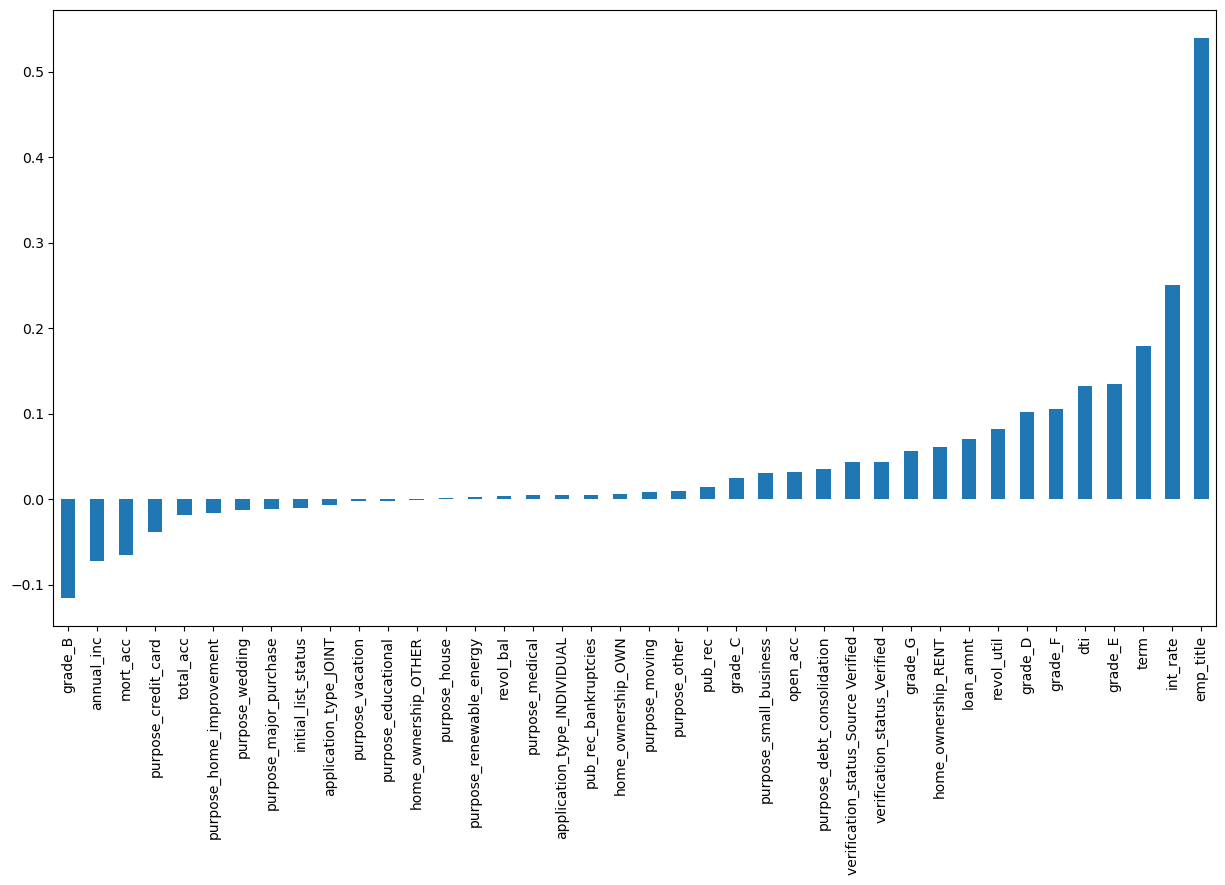

In [828]:
plt.figure(figsize=(15,8))

data.corr()["loan_status"].sort_values()[:-1].plot(kind = "bar")

# Data preparation for modeling: 

In [829]:
X = data.drop("loan_status",axis = 1)
y = data["loan_status"]

In [830]:
X.shape,y.shape

((355005, 41), (355005,))

### train-test-Split : 

In [831]:
from sklearn.model_selection import train_test_split

In [988]:
X_train , X_test,  y_train , y_test = train_test_split(X,y,
                                                      test_size=0.3,
                                                      random_state=42)

In [833]:
X_train.shape,X_test.shape

((248503, 41), (106502, 41))

In [989]:
X_train_non_scalled = X_train.copy()

In [990]:
X_test_non_scalled = X_test.copy()

## Scaling the data : 


In [991]:
from sklearn.preprocessing import StandardScaler

In [992]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [993]:
X_train = scaler.transform(X_train)

In [994]:
X_test = scaler.transform(X_test)

## Logistic Regression : 

### Handling Data Imbalance : 

In [840]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train.ravel())


In [841]:
## After over sampling : 
X_smote.shape, y_smote.shape

((401802, 41), (401802,))

## LogisticRegression

In [842]:
def apply_logistic_regression(X_train  ,y_train):
    
    from sklearn.linear_model import LogisticRegression
    logistic_reg_model = LogisticRegression(
        penalty='l2',         # L2 - ridge regularisation
        dual=False,
        tol=0.0001,
        C=1.0,             # 1/lambda : 
        fit_intercept=True,
        intercept_scaling=1,
        class_weight=None,
        random_state=None,
        solver='lbfgs',
        max_iter=1000,          # 1000 iterations for learning 
        multi_class='auto',
        verbose=0,
        warm_start=False,
        n_jobs=None,
        l1_ratio=None,)

    logistic_reg_model.fit(X_train,y_train)
    print("LR train score:",logistic_reg_model.score(X_train ,y_train))
    print("LR test score:",logistic_reg_model.score(X_test ,y_test))

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    y_predicted = logistic_reg_model.predict(X_test)
    
    print()
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test ,y_predicted ))

    ConfusionMatrixDisplay(confusion_matrix(y_test ,y_predicted ),
                          display_labels=[0,1]).plot()

    plt.show()

    from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
    from sklearn.metrics import classification_report

    print("fbeta score : beta : 0.5")
    print(fbeta_score(y_true = y_test,
        y_pred = y_predicted,
        beta = 0.5))

   

    print(classification_report(y_test, y_predicted))


    from sklearn.metrics import roc_auc_score,roc_curve
    from sklearn.metrics import precision_recall_curve

    print(precision_recall_curve_plot(y_test, logistic_reg_model.predict_proba(X_test)[:,1]))
    plt.show()
    

    
    def custom_predict(X, threshold):
            probs = logistic_reg_model.predict_proba(X) 
            return (probs[:, 1] > threshold).astype(int)

    # print(model.predict_proba(X_test))
    threshold = 0.83

    new_preds = custom_predict(X=X_test, threshold=threshold)


    print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


    print()
    print()




    print()
    print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                    beta = 0.5))
    print(classification_report(y_test, new_preds))

    
    
    print("Feature Importance : ")
    plt.figure(figsize=(15,8))

    pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T.plot(kind = "bar")
    plt.show()

LR train score: 0.8463671161417813
LR test score: 0.8490075303750164

Confusion Matrix: 
[[73519 12278]
 [ 3803 16902]]


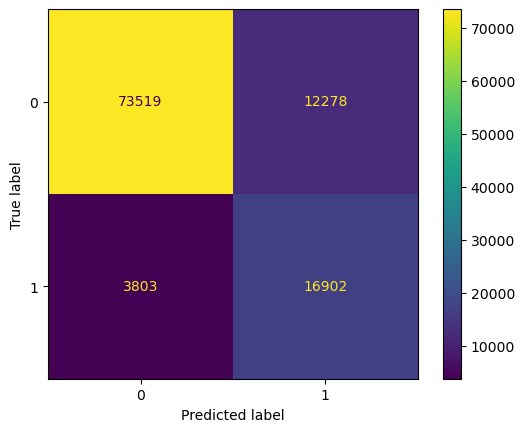

fbeta score : beta : 0.5
0.6149536110605786
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     85797
           1       0.58      0.82      0.68     20705

    accuracy                           0.85    106502
   macro avg       0.77      0.84      0.79    106502
weighted avg       0.88      0.85      0.86    106502



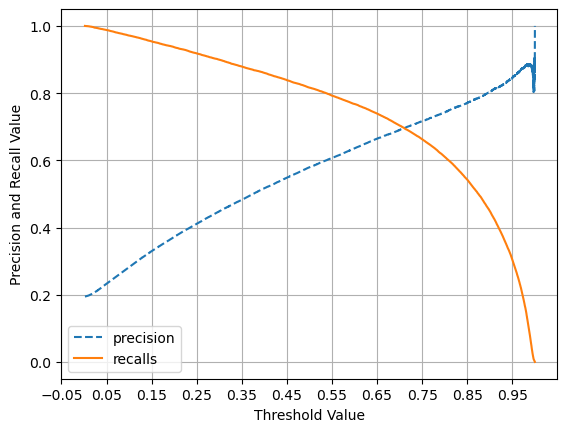

None
Precision at theshold 0.75 is :  0.7164116756305153



fbeta score : beta : 0.5 0.7049707632387548
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     85797
           1       0.72      0.66      0.69     20705

    accuracy                           0.88    106502
   macro avg       0.82      0.80      0.81    106502
weighted avg       0.88      0.88      0.88    106502

Feature Importance : 


<Figure size 1500x800 with 0 Axes>

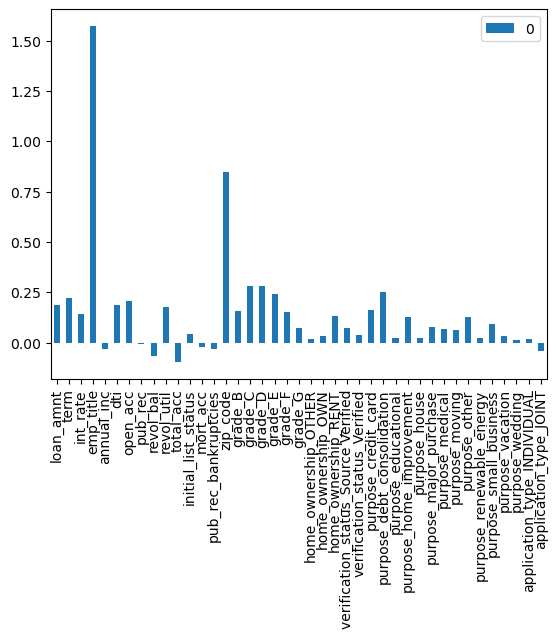

In [843]:
apply_logistic_regression(X_smote,y_smote)

LR train score: 0.8463671161417813
LR test score: 0.8490075303750164

Confusion Matrix: 
[[73519 12278]
 [ 3803 16902]]


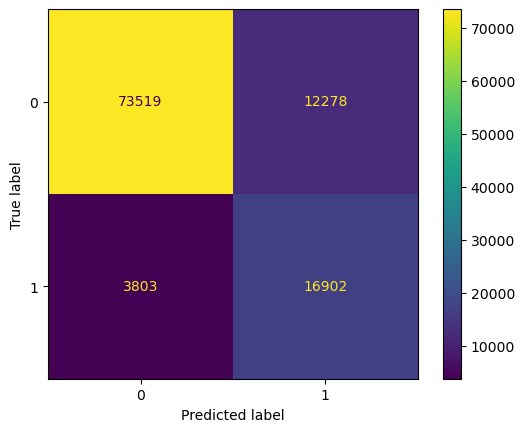

fbeta score : beta : 0.5
0.6149536110605786
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     85797
           1       0.58      0.82      0.68     20705

    accuracy                           0.85    106502
   macro avg       0.77      0.84      0.79    106502
weighted avg       0.88      0.85      0.86    106502



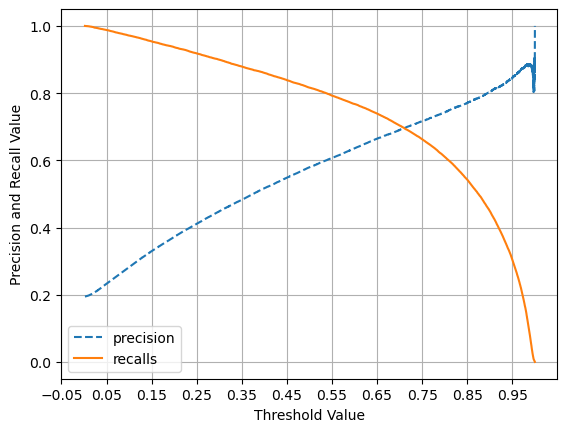

None
Precision at theshold 0.6 is :  0.6356328734253149



fbeta score : beta : 0.5 0.6582729343549388
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     85797
           1       0.64      0.77      0.70     20705

    accuracy                           0.87    106502
   macro avg       0.79      0.83      0.81    106502
weighted avg       0.88      0.87      0.87    106502



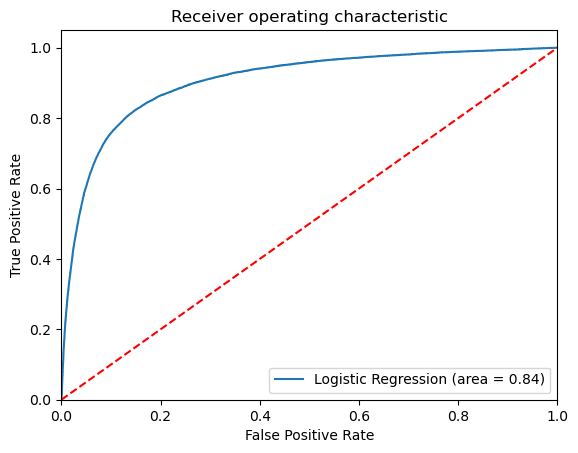

Feature Importance : 


<Figure size 1500x800 with 0 Axes>

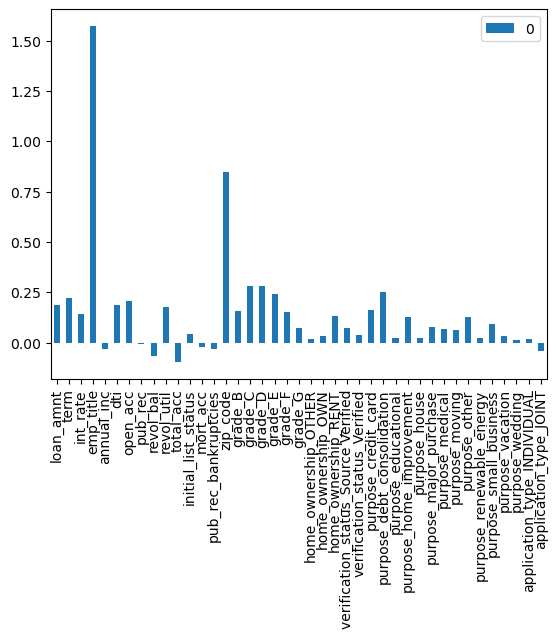

In [844]:

from sklearn.linear_model import LogisticRegression
logistic_reg_model = LogisticRegression(
    penalty='l2',         # L2 - ridge regularisation
    dual=False,
    tol=0.0001,
    C=1.0,             # 1/lambda : 
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=1000,          # 1000 iterations for learning 
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,)

logistic_reg_model.fit(X_smote,y_smote)
print("LR train score:",logistic_reg_model.score(X_smote,y_smote))
print("LR test score:",logistic_reg_model.score(X_test ,y_test))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_predicted = logistic_reg_model.predict(X_test)

print()
print("Confusion Matrix: ")
print(confusion_matrix(y_test ,y_predicted ))

ConfusionMatrixDisplay(confusion_matrix(y_test ,y_predicted ),
                      display_labels=[0,1]).plot()

plt.show()

from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print("fbeta score : beta : 0.5")
print(fbeta_score(y_true = y_test,
    y_pred = y_predicted,
    beta = 0.5))



print(classification_report(y_test, y_predicted))


from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve

print(precision_recall_curve_plot(y_test, logistic_reg_model.predict_proba(X_test)[:,1]))
plt.show()



def custom_predict(X, threshold):
        probs = logistic_reg_model.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))
threshold = 0.83

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()




print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))

logit_roc_auc = roc_auc_score(y_test, logistic_reg_model.predict_proba(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

print("Feature Importance : ")
plt.figure(figsize=(15,8))

pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T.plot(kind = "bar")
plt.show()

    

# DecisionTreeClassifier

In [847]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini',
                        splitter='best',
                        max_depth=14,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0,
                        max_features=None,
                        random_state=None,
                        max_leaf_nodes=None,
                        min_impurity_decrease=0.0,
                        class_weight="balanced",
                        ccp_alpha=0.0,)


In [848]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(model, X_smote, y_smote,
                                   cv=kfold, scoring='accuracy', n_jobs= -1))
print("Cross Validation accuracy: {:.3f}".format(accuracy))
model.fit(X_smote,y_smote)
print("test score:",model.score(X_test ,y_test))

Cross Validation accuracy: 0.934
test score: 0.9196916489831177


In [849]:
from sklearn.model_selection import GridSearchCV

In [856]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(1, 11)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
}
RS_DTC = RandomizedSearchCV(DTC, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit the model using random search
RS_DTC.fit(X_smote,y_smote)

# # Print the best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Get the best Decision Tree Classifier
DTmodel = RS_DTC.best_estimator_

Best parameters found:
{'min_samples_split': 7, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}


train score: 0.9545945515452885
test score: 0.914583763685189


Precision at theshold 0.83 is :  0.9266519127410686




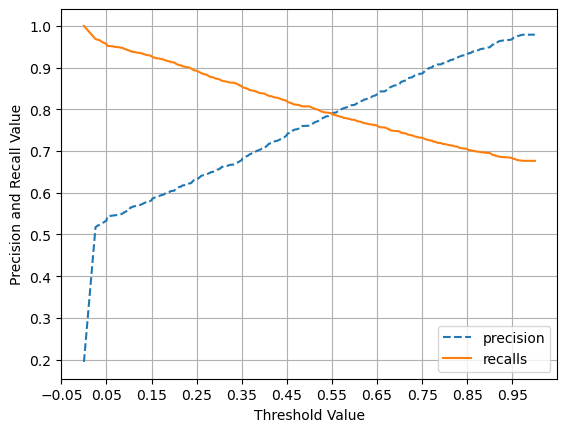

None

fbeta score : beta : 0.5 0.8726850473411539
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     85797
           1       0.93      0.71      0.80     20705

    accuracy                           0.93    106502
   macro avg       0.93      0.85      0.88    106502
weighted avg       0.93      0.93      0.93    106502



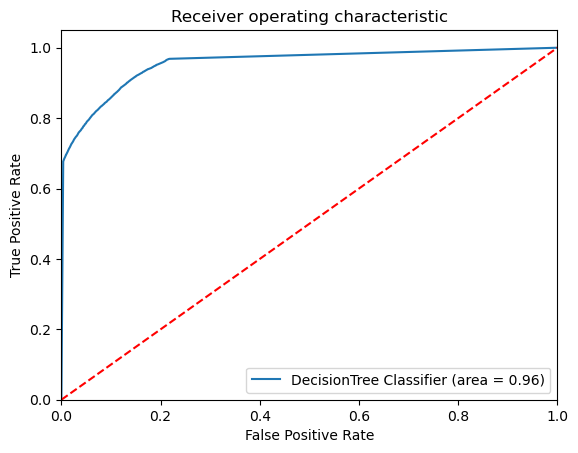

In [1088]:
DTmodel.fit(X_smote,y_smote)
print("train score:",DTmodel.score(X_smote ,y_smote))
print("test score:",DTmodel.score(X_test ,y_test))
y_predicted = DTmodel.predict(X_test)

from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



def custom_predict(X, threshold):
        probs = DTmodel.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    

threshold = 0.83

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()


print(precision_recall_curve_plot(y_test, DTmodel.predict_proba(X_test)[:,1]))
plt.show()

print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))

_roc_auc = roc_auc_score(y_test, DTmodel.predict_proba(X_test)[:,1])
_roc_auc
fpr, tpr, thresholds = roc_curve(y_test, DTmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DecisionTree Classifier (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DecisionTreeClassifier_ROC')
plt.show()



In [1087]:
roc_auc_score(y_test, DTmodel.predict_proba(X_test)[:,1])

0.9554705323546148

## RandomForestClassifier

train score: 0.9925162144538853
test score: 0.9071942310942518




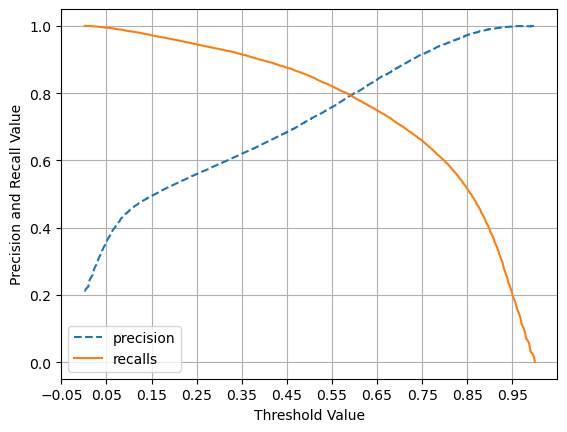

None
Precision at theshold 0.75 is :  0.9164313567298642



fbeta score : beta : 0.5 0.849802371541502
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     85797
           1       0.92      0.66      0.77     20705

    accuracy                           0.92    106502
   macro avg       0.92      0.82      0.86    106502
weighted avg       0.92      0.92      0.92    106502

True
0.9413989975161896




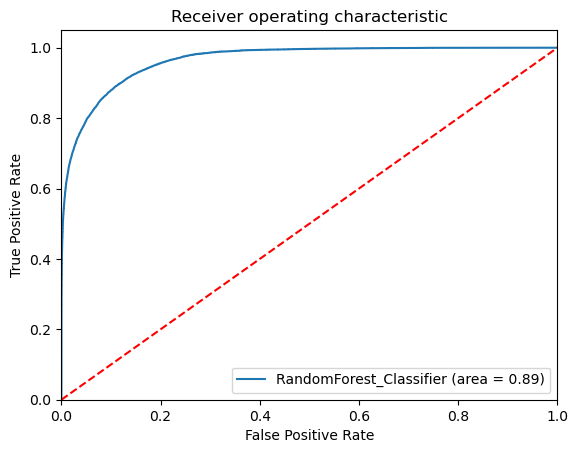

In [591]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(
                                    n_estimators=100,
                                    criterion='gini',
                                    max_depth=25,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features='sqrt',
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    bootstrap=True,
                                    oob_score=True,
                                    n_jobs=None,
                                    random_state=None,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None,
                                    ccp_alpha=0.0,
                                    max_samples=None,
                                   )
RFmodel.fit(X_smote,y_smote)
print("train score:",RFmodel.score(X_smote ,y_smote))
print("test score:",RFmodel.score(X_test ,y_test))
y_predicted = RFmodel.predict(X_test)
from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()


print(precision_recall_curve_plot(y_test, RFmodel.predict_proba(X_test)[:,1]))
plt.show()

def custom_predict(X, threshold):
        probs = RFmodel.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
threshold = 0.83

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()




print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))
print(RFmodel.oob_score)
print(RFmodel.oob_score_)



print()
print()



_roc_auc = roc_auc_score(y_test, RFmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RFmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest_Classifier (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RandomForest_Classifier_ROC')
plt.show()



In [592]:
confusion_matrix(y_test, new_preds)

array([[84554,  1243],
       [ 7074, 13631]], dtype=int64)

In [593]:
precision_score(y_test, new_preds)

0.9164313567298642

## GradientBoostingClassifier

In [594]:
from sklearn.ensemble import GradientBoostingClassifier

train score: 0.9444004758562675
test score: 0.92487465024131


Precision at theshold 0.83 is :  0.992384129977515




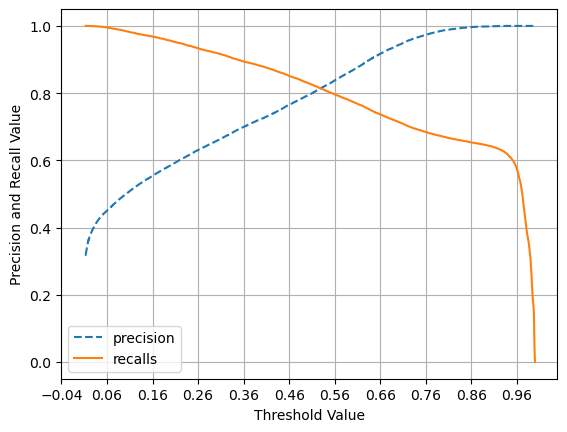

None

fbeta score : beta : 0.5 0.9018759969941862
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     85797
           1       0.99      0.66      0.79     20705

    accuracy                           0.93    106502
   macro avg       0.96      0.83      0.88    106502
weighted avg       0.94      0.93      0.93    106502



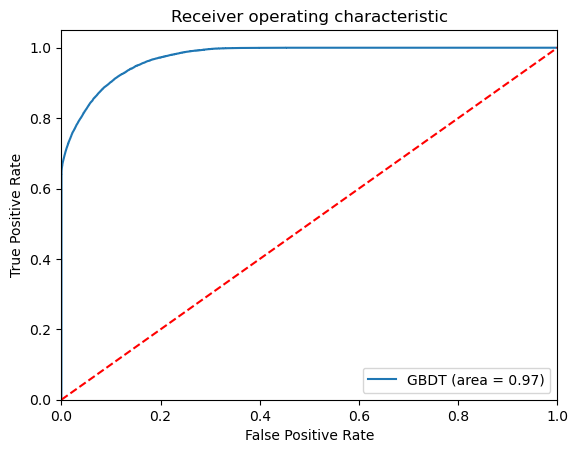

In [1089]:
from sklearn.tree import DecisionTreeClassifier
GBDTmodel = GradientBoostingClassifier(
                                    loss='deviance',
                                    learning_rate=0.1,
                                    n_estimators=150,
                                    subsample=1.0,
                                    criterion='friedman_mse',
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_depth=3,
                                    min_impurity_decrease=0.0,
                                    init=None,
                                    random_state=None,
                                    max_features=None,
                                    verbose=0,
                                    max_leaf_nodes=None,
                                    warm_start=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=None,
                                    tol=0.0001,
                                    ccp_alpha=0.0
                                   )
GBDTmodel.fit(X_smote,y_smote)
print("train score:",GBDTmodel.score(X_smote ,y_smote))
print("test score:",GBDTmodel.score(X_test ,y_test))
y_predicted = GBDTmodel.predict(X_test)
from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



def custom_predict(X, threshold):
        probs = GBDTmodel.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
threshold = 0.83

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, GBDTmodel.predict_proba(X_test)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





fpr, tpr, thresholds = roc_curve(y_test, GBDTmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GBDT (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GBDT_ROC')
plt.show()



In [1092]:
_roc_auc = roc_auc_score(y_test, GBDTmodel.predict_proba(X_test)[:,1])
_roc_auc

0.9742421622379354

In [156]:
 
#         0  1
#     0  TN  FP
#     1  FN  TP
    
#     TP/  FP + TP
    
#     TP / FN + TP

In [599]:
precision_score(y_test, new_preds)

0.9695362437100503

## XGBoost GBDT

In [600]:
from xgboost import XGBClassifier

In [601]:
xgbc = XGBClassifier(n_estimators = 70,max_depth =5)

train score: 0.9590644148112752
test score: 0.934724230530882


Precision at theshold 0.83 is :  0.9984083345391405




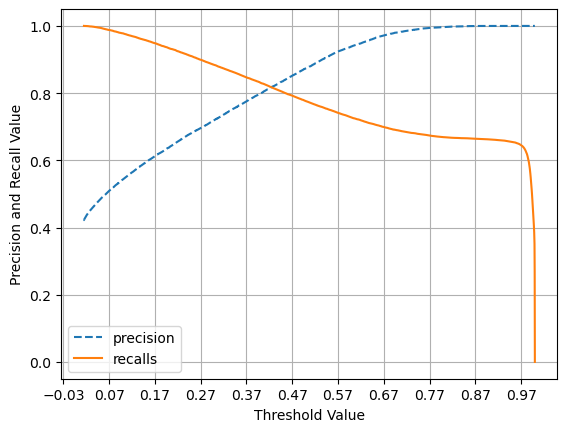

None

fbeta score : beta : 0.5 0.9079783664284868
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     85797
           1       1.00      0.67      0.80     20705

    accuracy                           0.93    106502
   macro avg       0.96      0.83      0.88    106502
weighted avg       0.94      0.93      0.93    106502



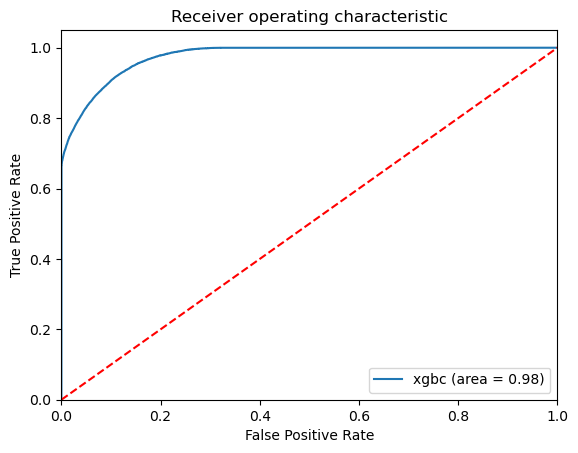

In [1090]:
xgbc.fit(X_smote,y_smote)
print("train score:",xgbc.score(X_smote ,y_smote))
print("test score:",xgbc.score(X_test ,y_test))
y_predicted = xgbc.predict(X_test)
from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



def custom_predict(X, threshold):
        probs = xgbc.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
threshold = 0.83

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, xgbc.predict_proba(X_test)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





fpr, tpr, thresholds = roc_curve(y_test, xgbc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()


In [1093]:
_roc_auc = roc_auc_score(y_test, xgbc.predict_proba(X_test)[:,1])
_roc_auc 

0.9758017366979896

#### Failed Attempt to apply KNeighborsClassifier :P 

In [162]:
# from sklearn.neighbors import KNeighborsClassifier

In [163]:
# kNN_model  = KNeighborsClassifier(n_neighbors=9)

In [164]:
# kNN_model.fit(X_smote,y_smote)
# print("train score:",kNN_model.score(X_train ,y_train))
# print("test score:",kNN_model.score(X_test ,y_test))
# y_predicted = kNN_model.predict(X_test)
# from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
# from sklearn.metrics import classification_report

# print()
# print()



# def custom_predict(X, threshold):
#         probs = kNN_model.predict_proba(X) 
#         return (probs[:, 1] > threshold).astype(int)
    
# # print(model.predict_proba(X_test))
# threshold = 0.75

# new_preds = custom_predict(X=X_test, threshold=threshold)


# print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


# print()
# print()

# print(precision_recall_curve_plot(y_test, kNN_model.predict_proba(X_test)[:,1]))
# plt.show()



# print()
# print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
#                                                 beta = 0.5))
# print(classification_report(y_test, new_preds))





# _roc_auc = roc_auc_score(y_test, kNN_model.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, kNN_model.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='kNN Classifier(area = %0.2f)' % _roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()


#### Feature Importance according to Random Forest Model :

In [ ]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(index=X.columns,data= RFmodel.feature_importances_)[0],
           y =pd.DataFrame(index=X.columns,data= RFmodel.feature_importances_).index)

#### Feature Importance according to Logitistc Regression Model :

In [ ]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T[0],
           y =pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T.index)

#### Feature Importance according to XGBoost Classifier Model :

In [ ]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(index=X.columns,data= xgbc.feature_importances_)[0],
           y =pd.DataFrame(index=X.columns,data= xgbc.feature_importances_).index)

In [614]:
X_smote

array([[-1.2207546 , -0.56096757,  1.0516416 , ..., 14.36170424,
         0.03056898, -0.02729492],
       [ 2.37781537,  1.78263425,  1.21925744, ..., -0.06962962,
         0.03056898, -0.02729492],
       [ 0.05220893, -0.56096757, -0.78307225, ..., -0.06962962,
         0.03056898, -0.02729492],
       ...,
       [-1.00099335,  1.78263425, -0.09098725, ..., -0.06962962,
         0.03056898, -0.02729492],
       [-0.02349167, -0.56096757,  0.9034821 , ..., -0.06962962,
         0.03056898, -0.02729492],
       [-1.13549327, -0.56096757, -0.2530438 , ..., -0.06962962,
         0.03056898, -0.02729492]])

## Final stacking models

In [ ]:
train_model_predictions = pd.DataFrame({'xgb_prediction':xgbc.predict_proba(X_smote)[:, 1],
'gb_prediction':GBDTmodel.predict_proba(X_smote)[:, 1],
'rf_prediction':RFmodel.predict_proba(X_smote)[:, 1],
'dt_prediction':DTmodel.predict_proba(X_smote)[:, 1],
'lr_prediction':logistic_reg_model.predict_proba(X_smote)[:, 1]})

In [ ]:
test_model_predictions = pd.DataFrame({'xgb_prediction':xgbc.predict_proba(X_test)[:, 1],
'gb_prediction':GBDTmodel.predict_proba(X_test)[:, 1],
'rf_prediction':RFmodel.predict_proba(X_test)[:, 1],
'dt_prediction':DTmodel.predict_proba(X_test)[:, 1],
'lr_prediction':logistic_reg_model.predict_proba(X_test)[:, 1]})

Logistic regression

In [726]:
from sklearn.linear_model import LogisticRegression
final_lr_model = LogisticRegression(
    penalty='elasticnet',         # L2 - ridge regularisation
    dual=False,
    tol=0.0001,
    fit_intercept=True,
    C = {best_c},
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='saga',
    max_iter=10000,          # 1000 iterations for learning 
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=0.5,)


params = {
    'C': np.logspace(-4, 4, 20)  # You can modify the range and the number of values as needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(final_lr_model, params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the model using grid search
grid_search.fit(train_model_predictions, y_smote)

# Get the best C-value
best_c = grid_search.best_params_['C']
print(f"Best C-value: {best_c}")

# Get the best logistic regression model


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C-value: 545.5594781168514


In [947]:

import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

best_final_logistic_regression = grid_search.best_estimator_

# Replace 'y_test' with the true labels of your test set
accuracy = best_final_logistic_regression.score(train_model_predictions, y_smote)
print(f"Train Accuracy: {accuracy}")
accuracy2 = best_final_logistic_regression.score(test_model_predictions, y_test)
print(f"Test Accuracy: {accuracy2}")

# y_pred_prob = best_final_logistic_regression.predict_proba(train_model_predictions)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_threshold = thresholds[np.argmax(f1_scores)]
# print("Best probability threshold:", best_threshold)
best_threshold = 0.83

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

stack_lr_train_pred = custom_predict(best_final_logistic_regression, train_model_predictions, best_threshold)
stack_lr_test_pred = custom_predict(best_final_logistic_regression, test_model_predictions, best_threshold)

Train Accuracy: 0.999161278440625
Test Accuracy: 0.9187245309947231


In [948]:
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_smote, stack_lr_train_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test, stack_lr_test_pred))

Precision at theshold 0.83 is :  0.9995962677193612
Precision at theshold 0.83 is :  0.8630927339383376


Precision at theshold 0.83 is :  0.8630927339383376




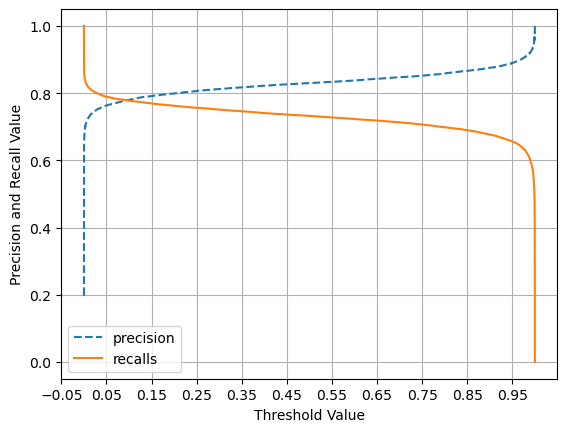

None

fbeta score : beta : 0.5 0.8228761989892392
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     85797
           1       0.86      0.69      0.77     20705

    accuracy                           0.92    106502
   macro avg       0.90      0.83      0.86    106502
weighted avg       0.92      0.92      0.92    106502

0.8479284994608715


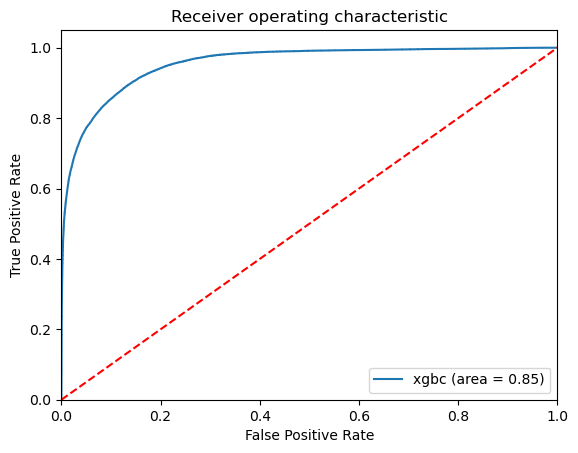

In [949]:

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))


new_preds = custom_predict(model = best_final_logistic_regression, X=test_model_predictions, threshold=best_threshold)


print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, best_final_logistic_regression.predict_proba(test_model_predictions)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





_roc_auc = roc_auc_score(y_test, best_final_logistic_regression.predict(test_model_predictions))
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, best_final_logistic_regression.predict_proba(test_model_predictions)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Decision Tree Classifier

In [727]:
from sklearn.model_selection import RandomizedSearchCV
final_lr_model = DecisionTreeClassifier()

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(1, 11)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
}

random_search = RandomizedSearchCV(final_lr_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit the model using random search
random_search.fit(train_model_predictions, y_smote)

# Print the best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Get the best Decision Tree Classifier
best_dtc = random_search.best_estimator_

best_final_dtr_regression = random_search.best_estimator_

In [1072]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

best_final_dtr_regression = random_search.best_estimator_

# Replace 'y_test' with the true labels of your test set
accuracy = best_final_dtr_regression.score(train_model_predictions, y_smote)
print(f"Train Accuracy: {accuracy}")
accuracy2 = best_final_dtr_regression.score(test_model_predictions, y_test)
print(f"Test Accuracy: {accuracy2}")

# y_pred_prob = best_final_dtr_regression.predict_proba(train_model_predictions)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_threshold = thresholds[np.argmax(f1_scores)]
# print("Best probability threshold:", best_threshold)
best_threshold = 0.83

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

stack_dtr_train_pred = custom_predict(best_final_dtr_regression, train_model_predictions, best_threshold)
stack_dtr_test_pred = custom_predict(best_final_dtr_regression, test_model_predictions, best_threshold)

Train Accuracy: 0.9996117490704377
Test Accuracy: 0.9238418057876847


In [1073]:
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_smote, stack_dtr_train_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test, stack_dtr_test_pred))

Precision at theshold 0.83 is :  0.9997560283405446
Precision at theshold 0.83 is :  0.8410617551462621


In [1078]:
pd.array(y_test)

<PandasArray>
[0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
 ...
 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Length: 106502, dtype: int64

Precision at theshold 0.83 is :  0.8410617551462621




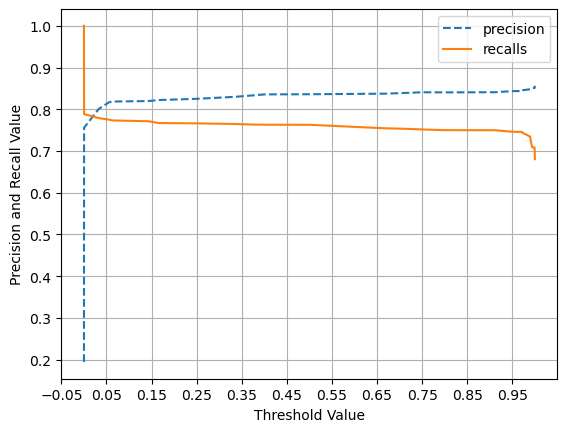

None

fbeta score : beta : 0.5 0.8210904860119519
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     85797
           1       0.84      0.75      0.79     20705

    accuracy                           0.92    106502
   macro avg       0.89      0.86      0.87    106502
weighted avg       0.92      0.92      0.92    106502

0.8746934101934626


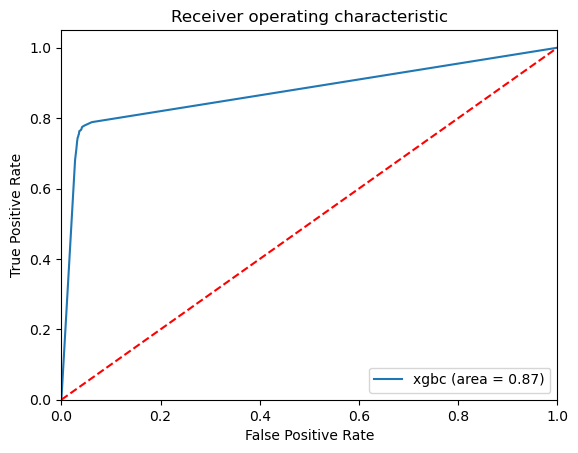

In [1097]:
def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))


new_preds = custom_predict(model = best_final_dtr_regression, X=test_model_predictions, threshold=best_threshold)


print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))


_roc_auc = roc_auc_score(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1])
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Mean of predictions

In [997]:
another_train_model = train_model_predictions.copy()

In [998]:
another_test_model = test_model_predictions.copy()

In [999]:
final_train_predictions = another_train_model.mean(axis=1)
final_test_predictions = another_test_model.mean(axis=1)


In [1055]:
another_train_model

,xgb_prediction,gb_prediction,rf_prediction,dt_prediction,lr_prediction
0,0.006142,0.022703,0.001078,0.000000,0.097168
1,0.999672,0.992232,0.965873,1.000000,0.826979
2,0.001832,0.009931,0.007105,0.000000,0.062226
3,0.015941,0.030722,0.007635,0.000000,0.303876
4,0.005857,0.008243,0.010478,0.000000,0.135508
...,...,...,...,...,...
401797,0.998487,0.980815,0.880225,1.000000,0.633154
401798,0.812456,0.644392,0.878078,0.947368,0.833088
401799,0.308095,0.156163,0.927036,0.434783,0.132181
401800,0.990833,0.957633,0.980113,1.000000,0.977053


In [1064]:
def custom_predict(X, best_threshold):
    return (X > best_threshold).astype(int)

final_train_classifications = custom_predict(final_train_predictions, best_threshold)
final_test_classifications = custom_predict(final_test_predictions, best_threshold)

In [1067]:
roc_auc_score(y_test, final_test_predictions)

0.9702647508625157

Precision at theshold 0.83 is :  0.9898597133272339


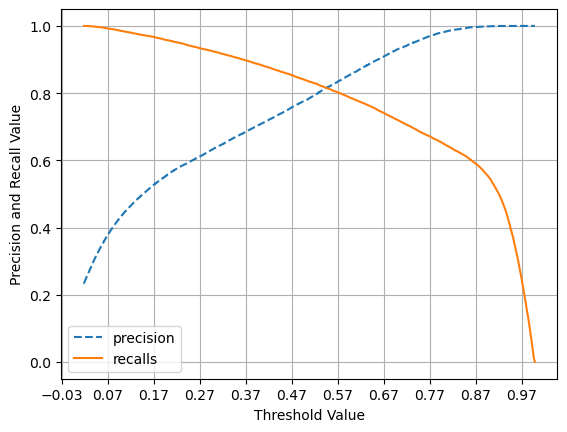

None
fbeta score : beta : 0.5 0.8871926635597043
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     85797
           1       0.99      0.63      0.77     20705

    accuracy                           0.93    106502
   macro avg       0.95      0.81      0.86    106502
weighted avg       0.93      0.93      0.92    106502

roc_auc score is 0.9702647508625157


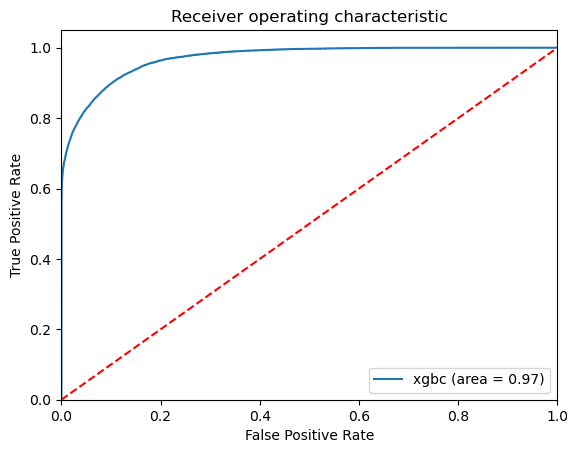

In [1070]:
new_preds = final_test_classifications

print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,final_test_classifications))



print(precision_recall_curve_plot(y_test, final_test_predictions))
plt.show()



print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))


_roc_auc = roc_auc_score(y_test, final_test_predictions)
print('roc_auc score is ' + str(_roc_auc) )
fpr, tpr, thresholds = roc_curve(y_test, final_test_predictions)
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('mean_stacker')
plt.show()

In [1050]:
X_train_null , X_test_null,  y_train , y_test = train_test_split(X,y,
                                                      test_size=0.3,
                                                      random_state=42)

In [1052]:
test_df = pd.DataFrame(X_test_null, columns=X.columns)
test_df['revenue'] = test_df['loan_amnt']*(100 + test_df['int_rate'])/100 * test_df['term']/12
profits = []
thresholds = []
for i in range(0,100):
    threshold = i/100
    good_customers = (final_test_predictions < threshold)
    thresholds.append(threshold)
    profits.append(sum(np.array(test_df['revenue'])[good_customers]*(1-final_test_predictions[good_customers])) - sum(np.array(test_df['loan_amnt'])[good_customers]*final_test_predictions[good_customers]))
thresholds_and_profits = pd.DataFrame({'thresholds': thresholds, 'profits':profits})
best_threshold = thresholds_and_profits[thresholds_and_profits['profits'] == thresholds_and_profits['profits'].max()]['thresholds']
best_threshold = float(best_threshold)
print('the best threshold is ' + str(best_threshold))

the best threshold is 0.83
